In [1]:
!/opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/bin/python -m pip install ucimlrepo


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/bin/python -m pip install --upgrade pip


## Data Retrieval

In [2]:
import os

import pandas as pd
import ucimlrepo
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, roc_curve)

In [68]:
import pandas as pd

# Direct approach
train = pd.read_csv("../dataset/train.csv")
val   = pd.read_csv("../dataset/validate.csv")
test  = pd.read_csv("../dataset/test.csv")

# Quick check
print(train.shape, val.shape, test.shape)

(31647, 40) (4521, 40) (9043, 40)


In [70]:
full_set = pd.concat([train,   val, test],   axis=1)
full_set.shape

(31647, 120)

In [72]:
features = [c for c in train.columns if c != "y"]
features

['age',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep']

In [79]:
X_train = train[features]
y_train = train['y']

X_val = val[features]
y_val = val['y']

X_test = test[features]
y_test = test['y']

# Data viz - full set

In [80]:
folder_path = os.path.join("..", "dataset")
data_path = os.path.join(folder_path, "data.csv")
labels_path = os.path.join(folder_path, "labels.csv")

def read_in_from_csv():
    x = pd.read_csv(data_path, sep=";")
    y = pd.read_csv(labels_path, sep=";")
    return x, y

x, y = read_in_from_csv()
variables = pd.read_csv(os.path.join(folder_path, "variables.csv"))

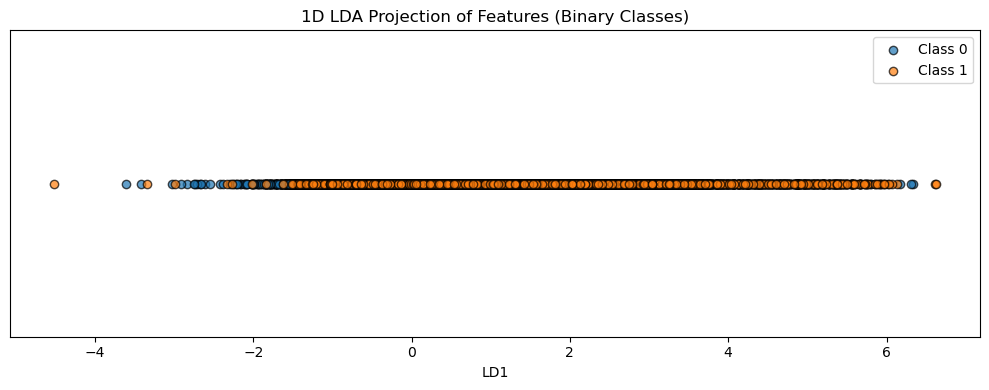

<Figure size 640x480 with 0 Axes>

In [82]:
# LDA plot shows that dataset is not easily linearly seperable
# The classes are not linearly separable in the original feature space.
# The features may not contain enough discriminative information to separate the classes.


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_train, y_train)

plt.figure(figsize=(10, 4))

# Plot each class separately with label
for class_label in sorted(set(y_train)):
    plt.scatter(
        X_lda[y_train == class_label],
        [0] * sum(y_train == class_label),
        label=f"Class {class_label}",
        edgecolors='k',
        alpha=0.7
    )

plt.xlabel("LD1")
plt.title("1D LDA Projection of Features (Binary Classes)")
plt.yticks([])
plt.legend()
plt.tight_layout()

plt.savefig('../images/lda-plot.png', dpi=300, bbox_inches='tight', transparent=True)  # Can also use .jpg, .svg, .pdf, etc.

plt.show()
plt.show()
plt.tight_layout()

# Model training

In [83]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=100000, random_state=42)
model.fit(X_train, y_train)

# Evaluate on the validation set
val_accuracy = model.score(X_val, y_val)
print(f"Validation accuracy: {val_accuracy:.4f}")

Validation accuracy: 0.8885


In [85]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_roc_curve(y_prob, y_test):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    
def plot_confusion_matrix(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    classification_report_output = classification_report(y_test, y_pred)
    accuracy_score_lib = accuracy_score(y_test, y_pred)

    tn = cm[0][0]
    tp = cm[1][1]
    fn = cm[1][0]
    fp = cm[0][1]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Predicted: 0", "Predicted: 1"],
        yticklabels=["Actual: 0", "Actual: 1"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    print(classification_report_output)
    print(f"Accuracy (Calculated): {accuracy}")
    print(f"Accuracy (Library): {accuracy_score_lib}")
    print(f"Recall: {recall}")
    print(f"precision: {precision}")

In [86]:
model.predict_proba(X_val)

array([[0.91201779, 0.08798221],
       [0.93402781, 0.06597219],
       [0.89484158, 0.10515842],
       ...,
       [0.92654426, 0.07345574],
       [0.95469068, 0.04530932],
       [0.90304228, 0.09695772]], shape=(4521, 2))

In [87]:
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]
y_prob

array([0.08798221, 0.06597219, 0.10515842, ..., 0.07345574, 0.04530932,
       0.09695772], shape=(4521,))

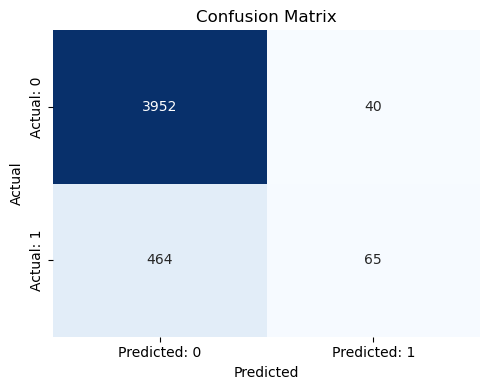

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      3992
           1       0.62      0.12      0.21       529

    accuracy                           0.89      4521
   macro avg       0.76      0.56      0.57      4521
weighted avg       0.86      0.89      0.85      4521

Accuracy (Calculated): 0.8885202388852024
Accuracy (Library): 0.8885202388852024
Recall: 0.12287334593572778
precision: 0.6190476190476191


In [88]:
plot_confusion_matrix(y_pred, y_val)

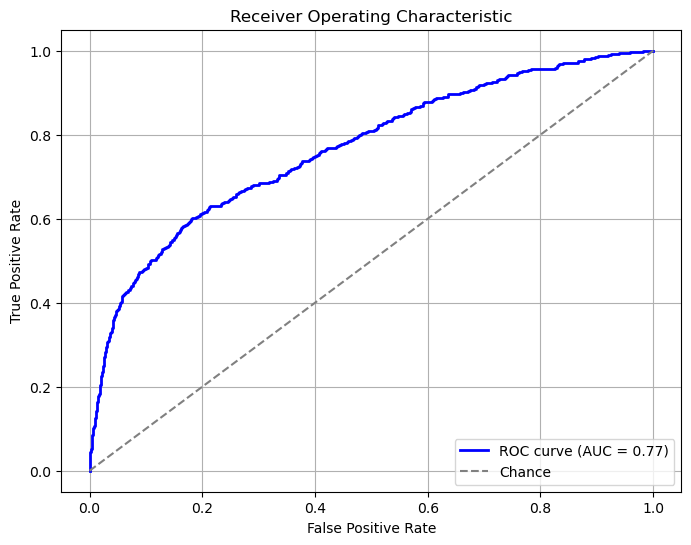

In [89]:
plot_roc_curve(y_prob, y_val)

# Hyperparameter Optimization

In [90]:
X_train

,age,education,default,balance,housing,loan,day_of_week,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,0.506494,2,0,0.083970,0,0,6,0.048387,-1,0,...,False,False,False,False,False,False,False,False,False,False
1,0.246753,3,0,0.072803,1,0,21,0.032258,175,1,...,False,False,False,False,False,False,False,True,False,False
2,0.181818,3,0,0.175531,0,0,23,0.000000,-1,0,...,False,False,False,False,False,False,True,False,False,False
3,0.441558,2,0,0.073757,0,1,22,0.048387,-1,0,...,False,False,False,True,False,False,False,False,False,False
4,0.428571,1,0,0.088183,0,0,13,0.016129,-1,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,0.493506,2,0,0.081628,0,0,30,0.016129,-1,0,...,False,False,True,False,False,False,False,False,False,False
31643,0.246753,2,0,0.076626,0,1,30,0.016129,-1,0,...,False,False,False,False,False,False,True,False,False,False
31644,0.103896,2,0,0.078541,0,0,12,0.032258,181,1,...,False,False,False,False,False,False,False,False,False,False
31645,0.519481,1,0,0.083117,0,0,17,0.032258,-1,0,...,False,False,False,False,True,False,False,False,False,False


In [91]:
y_train = y_train.values.ravel()
y_val   = y_val.values.ravel()
y_test  = y_test.values.ravel()

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

# Define a grid of common hyperparameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 20],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

# 1. Grid search optimizing for recall
grid_recall = GridSearchCV(
    LogisticRegression(max_iter=10000, random_state=42),
    param_grid,
    scoring='recall',
    cv=5
)
grid_recall.fit(X_train, y_train)
print("Recall-optimized best params:", grid_recall.best_params_)
print("CV recall:", grid_recall.best_score_)

Recall-optimized best params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
CV recall: 0.636691468796732


In [93]:
# 2. Grid search optimizing for precision
grid_precision = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    scoring='precision',
    cv=5
)
grid_precision.fit(X_train, y_train)
print("Precision-optimized best params:", grid_precision.best_params_)
print("CV precision:", grid_precision.best_score_)

# 3. Evaluate both models on the validation set
for name, model in [
    ('Recall-optimized', grid_recall.best_estimator_),
    ('Precision-optimized', grid_precision.best_estimator_)
]:
    y_val_pred = model.predict(X_val)
    print(f"\n{name} model validation scores:")
    print("  Recall   :", recall_score(y_val, y_val_pred))
    print("  Precision:", precision_score(y_val, y_val_pred))

Precision-optimized best params: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
CV precision: 0.6495024575578967

Recall-optimized model validation scores:
  Recall   : 0.6124763705103969
  Precision: 0.2852112676056338

Precision-optimized model validation scores:
  Recall   : 0.1266540642722117
  Precision: 0.7204301075268817


In [108]:
# 3. Grid search optimizing for f1 score
grid_f1 = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    scoring='f1',
    cv=5
)
grid_f1.fit(X_train, y_train)
print("F1-optimized best params:", grid_precision.best_params_)
print("CV F1:", grid_precision.best_score_)

F1-optimized best params: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
CV F1: 0.6495024575578967


In [124]:
# 3. Grid search optimizing for f1 score
grid_auc = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5
)
grid_auc.fit(X_train, y_train)
print("AUC-optimized best params:", grid_auc.best_params_)
print("CV auc:", grid_auc.best_score_)

AUC-optimized best params: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
CV auc: 0.7566526805055493


## Eval Best AUC Model

In [132]:
best_model = grid_auc.best_estimator_
best_model

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [133]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]
y_prob

array([0.10593978, 0.15496846, 0.19038038, ..., 0.34809661, 0.61890654,
       0.43688542], shape=(9043,))

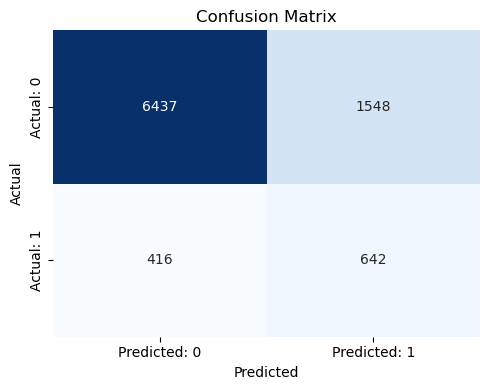

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      7985
           1       0.29      0.61      0.40      1058

    accuracy                           0.78      9043
   macro avg       0.62      0.71      0.63      9043
weighted avg       0.86      0.78      0.81      9043

Accuracy (Calculated): 0.7828154373548601
Accuracy (Library): 0.7828154373548601
Recall: 0.6068052930056711
precision: 0.29315068493150687


In [134]:
plot_confusion_matrix(y_pred, y_test)

In [135]:
y_test

array([0, 0, 0, ..., 0, 0, 0], shape=(9043,))

In [136]:
from sklearn.metrics import f1_score

# For binary classification
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

F1 Score: 0.39532019704433496


### plot_roc_curve(y_prob, y_val)

In [123]:
best_model = grid_precision.best_estimator_
best_model

LogisticRegression(C=0.01, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [116]:
y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)[:, 1]
y_prob

array([0.0592545 , 0.08509554, 0.11959166, ..., 0.104497  , 0.06257697,
       0.1589151 ], shape=(4521,))

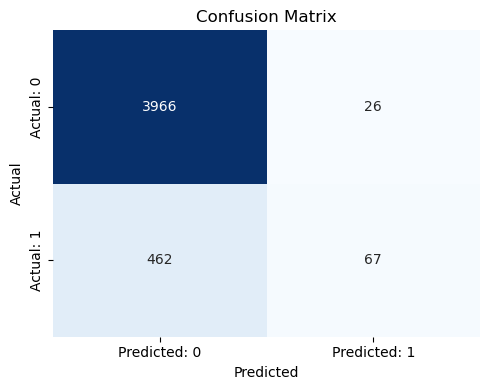

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3992
           1       0.72      0.13      0.22       529

    accuracy                           0.89      4521
   macro avg       0.81      0.56      0.58      4521
weighted avg       0.88      0.89      0.86      4521

Accuracy (Calculated): 0.8920592789205928
Accuracy (Library): 0.8920592789205928
Recall: 0.1266540642722117
precision: 0.7204301075268817


In [117]:
plot_confusion_matrix(y_pred, y_val)

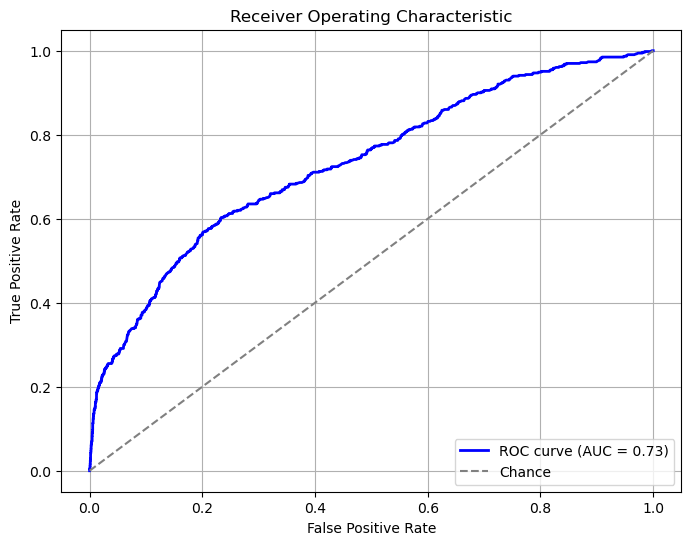

In [118]:
plot_roc_curve(y_prob, y_val)

# Model Viz

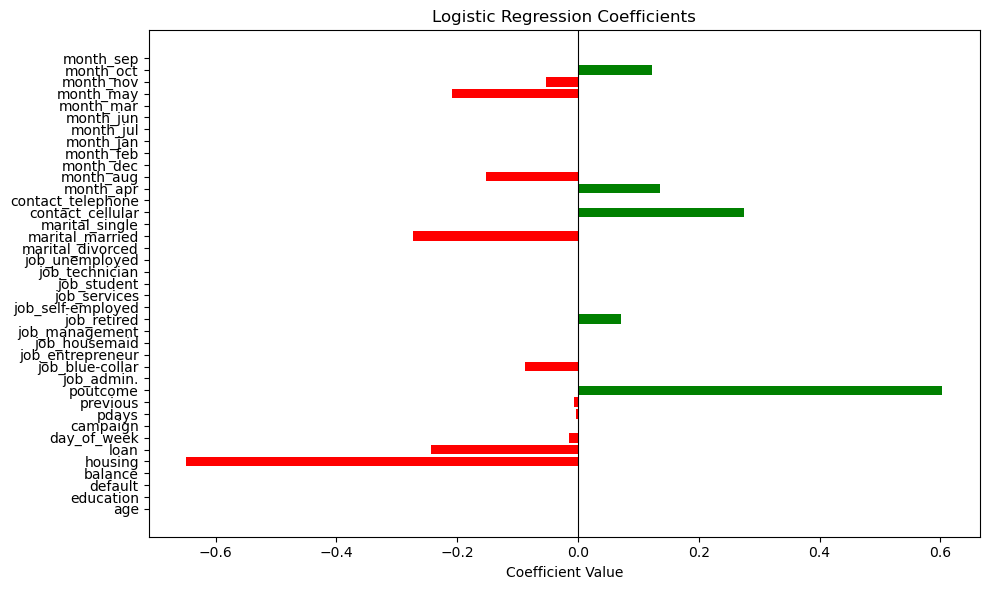

In [103]:
import matplotlib.pyplot as plt
import numpy as np

coefficients = best_model.coef_[0]
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, coefficients, color=['green' if c > 0 else 'red' for c in coefficients])
plt.axvline(0, color='black', linewidth=0.8)
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [104]:
from sklearn.decomposition import PCA


In [105]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_val)

# Create meshgrid in PCA space
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))



/opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


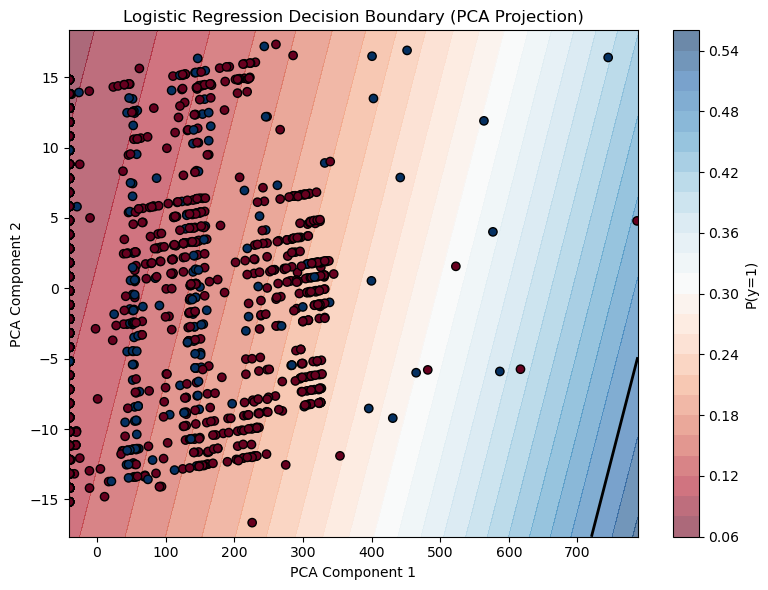

In [106]:
# Map meshgrid points back to original feature space
grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_original_space = pca.inverse_transform(grid_pca)

# Predict probabilities in original feature space
Z_pca = best_model.predict_proba(grid_original_space)[:, 1]
Z_pca = Z_pca.reshape(xx.shape)

# Plot decision boundary in PCA space
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_pca, levels=25, cmap="RdBu", alpha=0.6)
plt.colorbar(label='P(y=1)')
plt.contour(xx, yy, Z_pca, levels=[0.5], linewidths=2, colors='black')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_val, cmap="RdBu", edgecolors='k')
plt.title("Logistic Regression Decision Boundary (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()